<div style="border:solid green 2px; padding: 20px">
    
<b>Привет, Артём!</b>

Меня зовут Сергей Васильев, я буду проводить ревью твоего проекта. 

Предлагаю общаться на «ты», но если это неудобно, дай знать, и мы перейдем на "вы". 

Моя основная цель — поделиться опытом, помочь тебе подготовить проект максимально качественно для твоего в портфолио!
    
<div class="alert alert-danger">🔴</div>

>  Важные замечания. Их важно учесть, перед тем как показывать работу другим специалистам.

<div class="alert alert-warning">🟡</div>  

> Небольшие замечания. Если их ты тоже учтешь, твой проект станет только лучше.

<div class="alert alert-success">🟢</div>

> Правильные и верные действия, а также все остальные комментарии.

# Проект Мастерской "Классификация музыки"

Популярный музыкальный стримминговый сервис "МиФаСоль" расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача - правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. Сотрудники отдела работы со звуком подготовили датасет, в котором собраны некоторые характеристики музыкальных произведений и их жанры. Задача - разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

**Основные этапы исследования:**

1) Загрузка и ознакомление с данными  
2) Предварительная обработка  
3) Исследовательский анализ данных  
4) Выбор и обучение моделей  
5) Итоговая оценка качества предсказания лучшей модели и анализ важности ее признаков  
6) Общий вывод  

Импортируем полезные библиотеки, которые пригодятся нам в будущем

In [1]:
import numpy as np
import pandas as pd
import deezer
from collections import Counter
from math import floor, ceil
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import fbeta_score, roc_curve, roc_auc_score

Зададим параметры по умолчанию и объявим константы, которые понадобятся нам в дальнейшем

In [2]:
RANDOM_STATE = 510466
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)
pd.set_option('display.float_format', '{:.4f}'.format)
plt.rcParams["figure.figsize"] = (18, 12)
display(HTML("<style>.container {width:75% !important;}</style>"))
deezer_client = deezer.Client(headers={'Accept-Language': 'en'})
tqdm.pandas()

<div class="alert alert-success">🟢</div>

> Есть структура и этапы исследования.  
> Аккуратный упорядоченный импорт.  
> Константы и установки вынесены в отдельную ячейку.  
> Начальное впечатление обещает интересный проект! 

## Загрузка и ознакомление с данными

### Получим данные с информацией о музыкальных треках и сохраним их в соответсвующие переменные

In [3]:
train_data = pd.read_csv('./kaggle_music_genre_train.csv')
test_data = pd.read_csv('./kaggle_music_genre_test.csv')

### Ознакомимся с тренировочным набором данных. Выведем несколько строк из датафрейма, взятых случайным образом:

In [4]:
train_data.sample(10, random_state=RANDOM_STATE)

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
14990,24783.0000,On the River,0.4760,0.8640,-1.0000,0.3900,0.0000,C,0.0954,-5.5410,Major,0.1280,139.9960,4-Apr,0.1050,Rap
10505,41282.0000,Make It Sweet,0.0317,0.5390,-1.0000,0.8590,0.0000,G,0.1020,-4.4650,Major,0.0399,89.9370,4-Apr,0.4560,Country
7883,41501.0000,Closure,0.0009,0.2890,251800.0000,0.7360,0.0040,B,0.0636,-3.3800,Minor,0.0369,152.1580,3-Apr,0.1300,Rap
12753,52043.0000,Noise Machine,0.9560,0.4820,293253.0000,0.2230,0.0435,A#,0.0872,-13.8640,Minor,0.0401,157.1310,4-Apr,0.2950,Classical
18398,26819.0000,"Love, Love, Love",0.6830,0.4970,204056.0000,0.6360,0.0000,G#,0.2280,-8.7100,Major,0.0723,93.7770,4-Apr,0.6900,Jazz
16356,86807.0000,When I'm Small,0.1910,0.6460,249067.0000,0.7580,0.0970,A#,0.1030,-4.3400,Major,0.0314,91.9980,4-Apr,0.4240,Alternative
15504,86808.0000,Look Alive (feat. Drake),0.0010,0.9220,181263.0000,0.5810,0.0001,A#,0.1050,-7.4950,Major,0.2700,140.0220,4-Apr,0.5950,Rap
10246,72526.0000,Opium Trail,0.1710,0.2940,235013.0000,0.7740,0.0001,F,0.1500,-11.6700,Minor,0.0737,170.2170,4-Apr,0.7120,Blues
18201,21571.0000,Lux aeterna,0.9620,0.0663,-1.0000,0.0029,0.5690,D#,0.0893,-40.6940,Major,0.0486,75.7870,3-Apr,0.0193,Classical
453,39316.0000,When I Paint My Masterpiece - Remastered 2000,0.0367,0.4950,261267.0000,0.7140,0.0000,A#,0.4630,-8.2700,Major,0.0341,132.4340,4-Apr,0.5320,Blues


### Отобразим информацию для краткого обзора тренировочного набора данных:

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

### Отобразим таблицу с описательной статистикой признаков для тренировочного набора данных:

In [6]:
train_data.describe()

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,20394.0000,20394.0000,20394.0000,20394.0000,20394.0000,20394.0000,20394.0000,20394.0000,20394.0000,19952.0000,20394.0000
mean,55973.8469,0.2748,0.5620,220375.4253,0.6253,0.1600,0.1985,-8.5530,0.0914,120.9425,0.4646
std,20695.7925,0.3216,0.1719,126728.3261,0.2512,0.3065,0.1667,5.4999,0.0977,30.4276,0.2434
min,20011.0000,0.0000,0.0600,-1.0000,0.0010,0.0000,0.0136,-44.4060,0.0223,34.7650,0.0000
25%,38157.2500,0.0152,0.4510,177517.0000,0.4700,0.0000,0.0973,-10.2557,0.0356,95.9218,0.2720
50%,56030.0000,0.1200,0.5700,219533.0000,0.6660,0.0001,0.1300,-7.0520,0.0490,120.0125,0.4570
75%,73912.7500,0.4700,0.6830,266000.0000,0.8300,0.0845,0.2530,-5.0540,0.0956,141.9663,0.6530
max,91758.0000,0.9960,0.9780,4497994.0000,0.9990,0.9960,1.0000,3.7440,0.9420,220.0410,0.9920


### Отобразим таблицу с попарными корреляциями признаков для тренировочного набора данных:

In [7]:
train_data.corr().style.background_gradient(axis=None, cmap='Blues')  

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
instance_id,1.0000,0.0039,-0.0009,-0.0028,0.0048,0.0098,0.0023,-0.0001,-0.0134,-0.0111,0.0002
acousticness,0.0039,1.0000,-0.2734,0.0438,-0.7649,0.3168,-0.0918,-0.6997,-0.1446,-0.2148,-0.2217
danceability,-0.0009,-0.2734,1.0000,-0.1453,0.1827,-0.2538,-0.0808,0.3172,0.2580,-0.0598,0.3902
duration_ms,-0.0028,0.0438,-0.1453,1.0000,-0.0555,0.1415,0.0370,-0.0969,-0.0827,-0.0417,-0.1270
energy,0.0048,-0.7649,0.1827,-0.0555,1.0000,-0.3200,0.1768,0.8218,0.1505,0.2506,0.3480
instrumentalness,0.0098,0.3168,-0.2538,0.1415,-0.3200,1.0000,-0.0638,-0.4814,-0.1770,-0.0954,-0.2600
liveness,0.0023,-0.0918,-0.0808,0.0370,0.1768,-0.0638,1.0000,0.1066,0.0986,0.0389,0.0372
loudness,-0.0001,-0.6997,0.3172,-0.0969,0.8218,-0.4814,0.1066,1.0000,0.1521,0.2205,0.2840
speechiness,-0.0134,-0.1446,0.2580,-0.0827,0.1505,-0.1770,0.0986,0.1521,1.0000,0.0644,0.0316
tempo,-0.0111,-0.2148,-0.0598,-0.0417,0.2506,-0.0954,0.0389,0.2205,0.0644,1.0000,0.0856


<div class="alert alert-warning">🟡</div>

> Для наглядности можно построить график тепловой карты. [Пример](https://disk.yandex.ru/i/f4HWQTXBaQed7w).
>
> Для анализа коррелляций удобна библиотека **Phik**. Считает корреляции (и не только) в том числе и для категориальных признаков.

### Отобразим гистограммы распределений значений признаков для тренировочного набора данных:

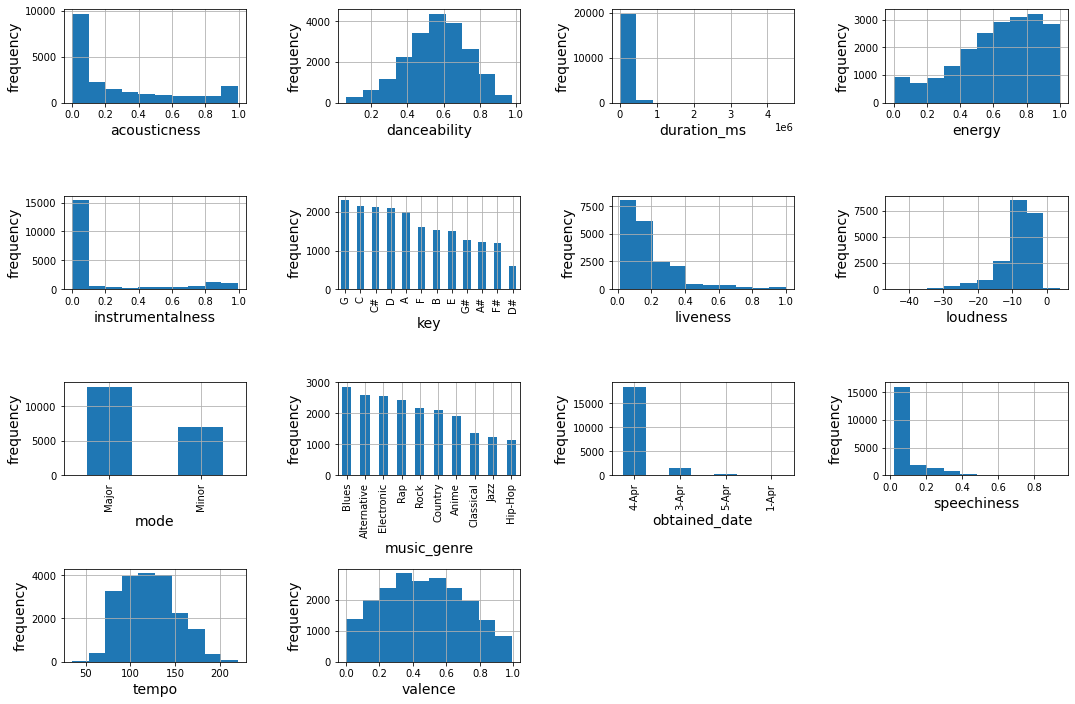

In [8]:
fig = plt.figure()
plt.subplots_adjust(wspace=0.5, hspace=1.0)

for i, col in enumerate(train_data.columns.difference(['instance_id', 'track_name'])):
    ax = fig.add_subplot(4, 4, i + 1)

    # Отобразим количественные и категориальные переменные соответствующими методами
    if np.issubdtype(train_data[col].dtype, np.number):
        train_data[col].plot(kind='hist')
    else:
        train_data[col].value_counts().plot(kind='bar')
        
    ax.set_xlabel(col, fontsize=14)
    ax.set_ylabel('frequency', fontsize=14)
    ax.grid(visible=True)

### Краткий вывод:

- в данных отсутствуют нарушения правила хорошего стиля в названиях столбцов
- в данных присутствуют несоответствия типов в столбцах `instance_id` и `duration_ms`. Исправим их на этапе предобработки данных
- в данных присутствуют явные пропуски в столбцах `key`, `mode`, `tempo`. Также в столбце `duration_ms` можно обнаружить пропуски в неявном виде со значением $-1.0$
- в данных присутствуют намёки на мультиколлинеарность. Например, коэффициент корреляции между признаками `loudness` и `energy` равен $0.8218$
- мелодии в большинстве музыкальных треков написаны в мажорном (`Major`) ладу

<div class="alert alert-success">🟢</div>

> Хорошая понятная визуализация и промежуточный вывод.  
> И автоматизированный выбор между `hist` и `bar`! 👍🏻

## Предварительная обработка

### Объявим дополнительные функции, которые понадобятся нам в дальнейшем

In [9]:
# Функция genre_from_name возвращает жанр, который содержится в названии музыкального трека в качестве подстроки
def genre_from_name(row):
    for genre in train_data.music_genre.unique():
        if genre.lower() in row.track_name.lower().split():
            return genre
        
    return None

# Функция genre_from_deezer возвращает жанр из поиска музыкальной библиотеки deezer по названию музыкального трека
def genre_from_deezer(row):
    try:
        genre_occurencies = Counter()
        tracks = deezer_client.search(track=row.track_name, dur_min=floor(row.duration_ms / 1000), dur_max=ceil(row.duration_ms / 1000))

        for track in tracks:
            if row.track_name.lower() in track.title.lower():
                genre_occurencies.update([deezer_client.get_genre(track.album.genre_id).name])
                
        return max(genre_occurencies, key=genre_occurencies.get)
    except:
        return None

### Исправим несоответствия типов в данных

In [10]:
train_data = train_data.astype({'instance_id': 'int64', 'duration_ms': 'int64'})
test_data = test_data.astype({'instance_id': 'int64', 'duration_ms': 'int64'})

### Добавим дополнительные признаки

Признак `track_name` в изначальном виде не очень полезен для прогнозирования жанра. Но из него можно сконструировать другие полезные признаки. Вот несколько вариантов как это можно сделать:

1) Название трека может содержать жанр как подстроку. Например трек с названием `Blues for Mama` содержит подстроку `Blues`  
2) По названию трека можно определить жанр при помощи поиска в музыкальных библиотеках, например через `Spotify API`, `Last.fm API`, `Shazam API`, `deezer API`, `Apple Music API`, `MusicBrainz API` и т.д.

К сожалению `Spotify API` не может быть использован для машинного обучения из-за ограничений в правилах пользования. (`Spotify content may not be used to train machine learning or AI model`) А `Last.fm API` содержит в себе кучу мусорных тегов. Проще всего удалось реализовать поиск при помощи `deezer API`. Будем пользоватся только этим ресурсом. Создадим новые признаки на основе этих двух вариантов

<div class="alert alert-success">🟢</div>

> Извлечь жанр из названия трека — великолепная идея! 👍🏻
>
> Использование стороннего сервиса для данного проекта, полагаю, тоже допустимо, поскольку это отличная тренировка нешаблонных навыков. Надеюсь, ты не используешь ответы сервиса напрямую для предсказания таргета ))

In [11]:
train_data['genre_from_name'] = train_data.progress_apply(genre_from_name, axis=1).fillna(np.nan)
test_data['genre_from_name'] = test_data.progress_apply(genre_from_name, axis=1).fillna(np.nan)

train_data['genre_from_deezer'] = train_data.progress_apply(genre_from_deezer, axis=1).fillna(np.nan)
test_data['genre_from_deezer'] = test_data.progress_apply(genre_from_deezer, axis=1).fillna(np.nan)

test_data['music_genre'] = 'Unknown'

100%|██████████| 5099/5099 [1:42:08<00:00,  1.20s/it]  


Теперь удалим неинформативные признаки, которые не несут ценности для прогноза:
- признак `instance_id` никак не связан с целевым признаком `music_genre`
- признак `track_name` сам по себе не очень полезен для прогнозирования целевого признака `music_genre`

In [12]:
train_data.drop(['instance_id', 'track_name'], inplace=True, axis=1, errors='ignore')
test_data.drop(['instance_id', 'track_name'], inplace=True, axis=1, errors='ignore')

### Закодируем переменные

Представим пропуски в столбце `duration_ms` в явном виде

In [13]:
train_data.loc[train_data.duration_ms < 0, 'duration_ms'] = np.nan
test_data.loc[test_data.duration_ms < 0, 'duration_ms'] = np.nan

Будем использовать метод `OrdinalEncoding` и в будущем учтём, что линейные модели плохо работают с таким методом кодирования

In [14]:
categorical = ['key', 'mode', 'obtained_date', 'music_genre', 'genre_from_name', 'genre_from_deezer']
encoder = OrdinalEncoder(encoded_missing_value=np.nan, handle_unknown='use_encoded_value', unknown_value=np.nan)
encoder.fit(train_data[categorical])

train_data[categorical] = pd.DataFrame(encoder.transform(train_data[categorical]), index=train_data[categorical].index)
test_data[categorical] = pd.DataFrame(encoder.transform(test_data[categorical]), index=test_data[categorical].index)

<div class="alert alert-success">🟢</div>

> Полезные сопутствующие комментарии на протяжении всего проекта!

### Очистим данные от пропусков

Посчитаем количество пропусков для каждого столбца

In [15]:
train_data.isna().sum()

acousticness             0
danceability             0
duration_ms           2009
energy                   0
instrumentalness         0
key                    735
liveness                 0
loudness                 0
mode                   506
speechiness              0
tempo                  442
obtained_date            0
valence                  0
music_genre              0
genre_from_name      20117
genre_from_deezer    11738
dtype: int64

- заполним пропуски в категориальных признаках `genre_from_name` и `genre_from_deezer` константным значением $-1.0$
- заполним пропуски в категориальных признаках `key`, `mode` алгоритмом ближайшего соседа с параметром $n\_neighbors = 1$ для того, чтобы не получить дробные значения
- заполним пропуски в количественных признаках `duration_ms` и `tempo` при помощи того же самого алгоритма ближайшего соседа

In [16]:
simple_columns = ['genre_from_name', 'genre_from_deezer']
simple_imputer = SimpleImputer(strategy='constant', fill_value=-1.0)
simple_imputer.fit(train_data[simple_columns])
train_data[simple_columns] = pd.DataFrame(simple_imputer.transform(train_data[simple_columns]), index=train_data[simple_columns].index)
test_data[simple_columns] = pd.DataFrame(simple_imputer.transform(test_data[simple_columns]), index=test_data[simple_columns].index)

knn_columns = train_data.columns.difference(simple_columns)
knn_imputer = KNNImputer(n_neighbors=1)
knn_imputer.fit(train_data[knn_columns])
train_data[knn_columns] = pd.DataFrame(knn_imputer.transform(train_data[knn_columns]), index=train_data[knn_columns].index)
test_data[knn_columns] = pd.DataFrame(knn_imputer.transform(test_data[knn_columns]), index=test_data[knn_columns].index)

<div class="alert alert-success">🟢</div>

> Хорошее решение для заполнения пропусков.  
> И метод `difference` применен красиво!

> Можно попробовать [IterativeImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html)  и сравнить результаты.

Снова посчитаем количество пропусков для каждого столбца

In [17]:
train_data.isna().sum()

acousticness         0
danceability         0
duration_ms          0
energy               0
instrumentalness     0
key                  0
liveness             0
loudness             0
mode                 0
speechiness          0
tempo                0
obtained_date        0
valence              0
music_genre          0
genre_from_name      0
genre_from_deezer    0
dtype: int64

### Очистим данные от дубликатов

Удалим из данных полные дубликаты

In [18]:
print('Количество полных дубликатов до удаления:', train_data[train_data.duplicated()].size)
train_data = train_data.drop_duplicates().reset_index(drop=True)
print('Количество полных дубликатов после удаления:', train_data[train_data.duplicated()].size)

Количество полных дубликатов до удаления: 80
Количество полных дубликатов после удаления: 0


Попробуем найти неполные дубликаты в данных

In [19]:
duplicated = train_data.duplicated(subset=['duration_ms', 'key', 'mode', 'tempo', 'loudness'], keep=False)
train_data[duplicated].sort_values(by='tempo').head(10)

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre,genre_from_name,genre_from_deezer
11296,0.0319,0.6800,273547.0000,0.6130,0.2360,4.0000,0.0730,-5.9590,0.0000,0.0612,58.0990,2.0000,0.6230,5.0000,-1.0000,9.0000
2760,0.0319,0.6800,273547.0000,0.6130,0.2360,4.0000,0.0730,-5.9590,0.0000,0.0612,58.0990,2.0000,0.6230,0.0000,-1.0000,9.0000
11593,0.4730,0.5190,207547.0000,0.3200,0.8460,0.0000,0.1100,-11.2380,1.0000,0.0293,60.9330,2.0000,0.0517,7.0000,-1.0000,18.0000
8211,0.4730,0.5190,207547.0000,0.3200,0.8460,0.0000,0.1100,-11.2380,1.0000,0.0293,60.9330,2.0000,0.0517,5.0000,-1.0000,18.0000
11263,0.4820,0.5350,201000.0000,0.4250,0.0003,3.0000,0.0842,-8.3920,0.0000,0.0292,64.7120,2.0000,0.2390,2.0000,-1.0000,-1.0000
1915,0.4820,0.5350,201000.0000,0.4250,0.0003,3.0000,0.0842,-8.3920,0.0000,0.0292,64.7120,2.0000,0.2390,9.0000,-1.0000,-1.0000
3272,0.1660,0.5670,321080.0000,0.3090,0.0000,11.0000,0.1200,-14.2540,0.0000,0.3850,65.0410,2.0000,0.5090,6.0000,-1.0000,20.0000
18662,0.1660,0.5670,321080.0000,0.3090,0.0000,11.0000,0.1200,-14.2540,0.0000,0.3850,65.0410,2.0000,0.5090,8.0000,-1.0000,20.0000
11028,0.9820,0.1440,279560.0000,0.0790,0.8980,1.0000,0.4020,-22.9930,1.0000,0.0363,65.6300,2.0000,0.2450,3.0000,-1.0000,-1.0000
11631,0.9820,0.1440,279560.0000,0.0790,0.8980,1.0000,0.4020,-22.9930,1.0000,0.0363,65.6300,2.0000,0.2450,1.0000,-1.0000,-1.0000


<div class="alert alert-warning">🟡</div>

> Возможно, неявные дубликаты, которые ты обнаружил, лучше удалить на самом раннем этапе: до изучения распределений, создания новых признаков и заполнения пропусков. Чтобы дубликаты не вносили свое влияние.

> *Кстати, возвращаясь к теме сторонних сервисов: нередко для альбома они указывают более одного жанра. Это могло стать одной из причин появления неявных дубликатов при создания датасета для этого проекта.*

Самый простой способ избавиться от неполных дубликатов — из нескольких таких строк отставить только первую. Более продвинутый вариант — обучить простой алгоритм классификации, чтобы спрогнозировать какая из строк-дубликатов наиболее правдободобна и оставить только её. Обучим алгоритм `DecisionTreeClassifier` на данных без дубликатов, а затем спрогнозируем — какую из строк дубликатов лучше удалить, а какую оставить

In [20]:
estimator = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
                         param_grid={
                             'criterion': ['gini', 'entropy'],
                             'max_depth': list(range(1, 51)),
                             'min_samples_split': list(range(2, 12))
                         },
                         n_jobs=-1,
                         cv=5,
                         verbose=10).fit(train_data[~duplicated].drop(['music_genre'], axis=1), 
                                         train_data.loc[~duplicated, 'music_genre']).best_estimator_

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
[CV 1/5; 1/1000] START criterion=gini, max_depth=1, min_samples_split=2.........
[CV 1/5; 1/1000] END criterion=gini, max_depth=1, min_samples_split=2;, score=0.106 total time=   0.0s
[CV 2/5; 1/1000] START criterion=gini, max_depth=1, min_samples_split=2.........
[CV 2/5; 1/1000] END criterion=gini, max_depth=1, min_samples_split=2;, score=0.104 total time=   0.0s
[CV 3/5; 1/1000] START criterion=gini, max_depth=1, min_samples_split=2.........
[CV 3/5; 1/1000] END criterion=gini, max_depth=1, min_samples_split=2;, score=0.104 total time=   0.0s
[CV 4/5; 1/1000] START criterion=gini, max_depth=1, min_samples_split=2.........
[CV 4/5; 1/1000] END criterion=gini, max_depth=1, min_samples_split=2;, score=0.104 total time=   0.0s
[CV 5/5; 1/1000] START criterion=gini, max_depth=1, min_samples_split=2.........
[CV 5/5; 1/1000] END criterion=gini, max_depth=1, min_samples_split=2;, score=0.106 total time=   0.0s
[CV 1/5; 2/1000

Создадим таблицу, в которой будут храниться вероятности для каждой строки принадлежать к каждому жанру

In [21]:
proba_by_class = pd.DataFrame(estimator.predict_proba(train_data.drop(['music_genre'], axis=1)), columns=estimator.classes_)
proba_by_class.head()

,0.0000,1.0000,2.0000,3.0000,4.0000,5.0000,6.0000,7.0000,8.0000,9.0000
0,0.0000,0.0000,0.0971,0.0000,0.4615,0.0268,0.0000,0.2801,0.0305,0.1041
1,0.0137,0.0000,0.6709,0.0000,0.0799,0.0000,0.0000,0.0000,0.0000,0.2355
2,0.0505,0.0000,0.0000,0.0000,0.0393,0.0186,0.5796,0.0000,0.3086,0.0034
3,0.0697,0.0000,0.0176,0.0000,0.0526,0.0272,0.3641,0.0081,0.4506,0.0101
4,0.1367,0.0399,0.0180,0.0000,0.1470,0.0398,0.1892,0.0000,0.3455,0.0838


Посчитаем вероятность для каждой строки принадлежать к жанру из столбца `music_genre`. Затем отсортируем датафрейм по этому значению и среди строк-дубликатов оставим только ту, у которой эта вероятность наибольшая, т.е. самую правдоподобную строку-дубликат

In [22]:
train_data['genre_proba'] = train_data.apply(lambda row: proba_by_class.loc[row.name, row.music_genre], axis=1)
train_data = train_data.sort_values(by='genre_proba', ascending=False)
train_data = train_data.drop_duplicates(subset=['duration_ms', 'key', 'mode', 'tempo', 'loudness'], keep='last')
train_data = train_data.drop('genre_proba', axis=1)

<div class="alert alert-success">🟢</div>

> Неординарный способ удаления дубликатов. Для соревнования важна любая мелочь! 👍🏻
>
> Может, **Catboost**? В данном случае его способность показывать хороший результат "из коробки" будет к месту.  
>
> Для обучения `estimator` ты подаешь набор, из которого исключены все дубликаты, кроме первого. Проверь, пожалуйста, нет ли в этом нарушения логики. Возможно, стоит оставить все дубликаты или, наоборот, все исключить.  
> Если я неправильно понял твою логику, прошу извинить ))

### Отфильтруем аномальные значения

Отфильтруем аномальные значения в столбцах, которые имеют длинные хвосты в распределении значений, то есть столбцы `duration_ms`, `loudness` и `tempo`. Аномальными будем считать те значения, которые меньше $Q_{1} = 0.01$ или больше $Q_{2} = 0.99$. Эти значения - эвристики. Возможно они являются не самыми оптимальными, но тем не менее они позволяют нам избавиться от аномальных значений, при этом не сильно уменьшая размер выборки

<div class="alert alert-success">🟢</div>

> Далеко не всегда то, что статистически является выбросом, ухудшает качество модели.  
>
> Более того, можно избавиться от "неудобных" данных, и при этом качество модели на обучающей выборке улучшится.  
> Но урезая диапазон данных для обучения, мы сокращаем область применимости модели. Другими словами, модель может выдавать неадекватный результат, если входные данные выйдут из указанного диапазона.  
>  
> Решение о сокращении области применимости модели может быть осознанным, если недостаточно данных для качественной работы модели в каком-либо диапазоне, или по другим причинам.  
> В любом случае стоит уведомить заказчика или пользователей об области применимости модели.

> По возможности, стоит проводить эксперименты с моделью, чтобы убедиться в правильности решения об удалении данных.

Количество отфильтрованных значений по столбцу duration_ms: 398 (2.0422%)
Количество отфильтрованных значений по столбцу loudness: 390 (2.042%)
Количество отфильтрованных значений по столбцу tempo: 382 (2.0409%)


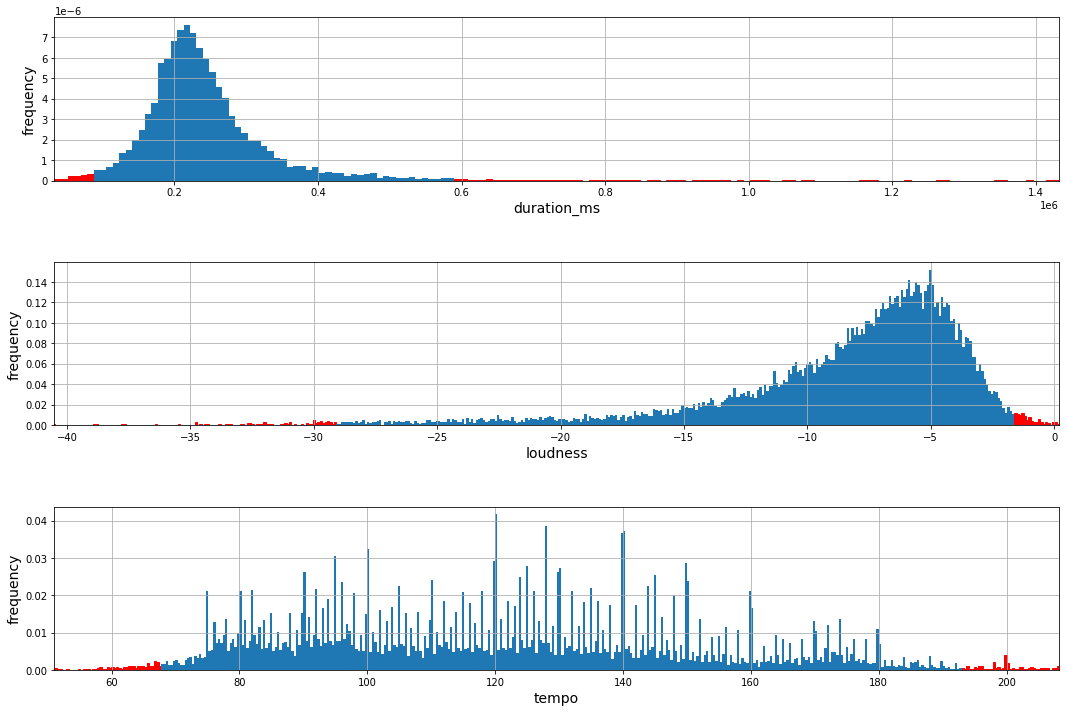

In [23]:
fig = plt.figure()
plt.subplots_adjust(hspace=0.5)

for i, col in enumerate(['duration_ms', 'loudness', 'tempo']):
    ax = fig.add_subplot(3, 1, i + 1)
    lower = train_data[col].quantile(0.01)
    higher = train_data[col].quantile(0.99)
    
    train_data[col].plot(kind='hist', bins=500, density=True, grid=True, xlim=(train_data[col].quantile(0.0005), train_data[col].quantile(0.9995)))
    ax.set_xlabel(col, fontsize=14)
    ax.set_ylabel('frequency', fontsize=14)
    
    for rect in ax.patches:
        if rect.get_x() < lower or higher < rect.get_x():
            rect.set_color('red')
    
    # Фильтруя датафрейм по какому-либо значению, не стоит забывать про пропуски, хотя в нашем случае это уже не актуально
    filtered = (train_data[col].isna()) | ((lower <= train_data[col]) & (train_data[col] <= higher))
    filtered_size = train_data[~filtered].shape[0]
    train_data = train_data[filtered]
    print(f'Количество отфильтрованных значений по столбцу {col}: {filtered_size} ({round(filtered_size / train_data.shape[0] * 100, 4)}%)')

<div class="alert alert-success">🟢</div>

> Отличная визуализация!

### Разделим данные на тренировочную и валидационную выборки

Разделим тренировочный набор данных на обучающую и валидационную выборки. Также разобъём данные на две группы — признаки для прогнозирования и целевой признак. Воспользуемся аргументом `stratify` для сохранения дисбаланса классов в выборках

In [24]:
train_data, valid_data = train_test_split(train_data, test_size=0.2, random_state=RANDOM_STATE, stratify=train_data.music_genre)

# Разделим данные в тренировочной выборке
train_features = train_data.drop(['music_genre'], axis=1) 
train_target = train_data['music_genre']

# Разделим данные в валидационной выборке
valid_features = valid_data.drop(['music_genre'], axis=1)
valid_target = valid_data['music_genre']

### Краткий вывод:

- исправили несоответсвтия типов в данных
- добавили дополнительные признаки
- закодировали категориальные переменные методом `OrdinalEncoding`
- очистили данные от пропусков
- очистили данные от полных и неполных дубликатов при помощи алгоритма `DecisionTreeClassifier`
- отфильтровали аномальные значения по квантилям $Q_{1} = 0.01$ и $Q_{2} = 0.99$

## Разведочный анализ данных

### Создадим копию тренировочных данных без кодирования. Она понадобится нам в будущем для отрисовывавания графиков

In [25]:
decoded_train = train_data.copy()
decoded_train[categorical] = encoder.inverse_transform(decoded_train[categorical])
decoded_train.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre,genre_from_name,genre_from_deezer
7491,0.0000,0.5030,273427.0000,0.9830,0.0077,E,0.2730,-4.9430,Major,0.1090,115.0410,4-Apr,0.2310,Classical,NaN,NaN
13718,0.0300,0.8410,253680.0000,0.7830,0.5340,D#,0.0311,-9.6860,Minor,0.1250,121.0970,4-Apr,0.7460,Jazz,NaN,NaN
16530,0.0001,0.5310,228713.0000,0.9760,0.4060,C#,0.0729,-4.7000,Minor,0.0669,100.9840,4-Apr,0.4550,Alternative,NaN,Rock
2227,0.0076,0.4300,222135.0000,0.9960,0.0000,D,0.2790,-4.9290,Major,0.1460,181.0270,3-Apr,0.3490,Blues,NaN,Rock
13536,0.0000,0.4460,173160.0000,0.9330,0.0001,A,0.0850,-3.6050,Major,0.0537,159.9610,4-Apr,0.7530,Alternative,NaN,Metal


### Проанализируем дисбаланс классов в целевом признаке

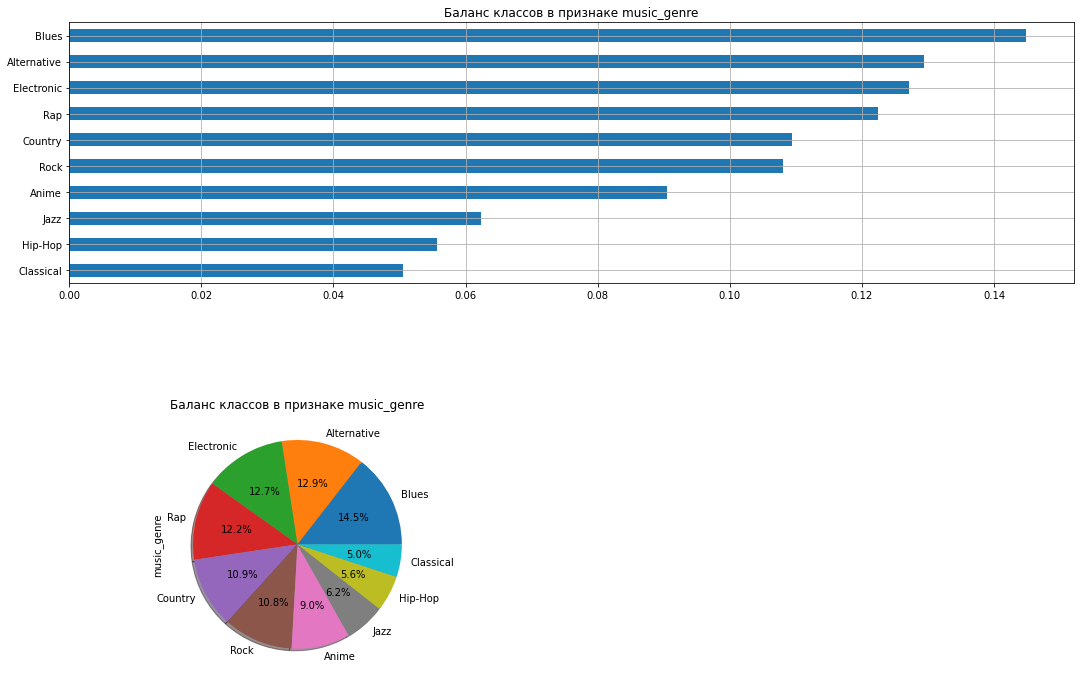

In [26]:
fig = plt.figure()
plt.subplots_adjust(hspace=0.5)

ax = fig.add_subplot(2, 1, 1)
decoded_train.music_genre.value_counts(normalize=True).sort_values(ascending=True).plot(kind='barh', 
                                                                                        title='Баланс классов в признаке music_genre',
                                                                                        legend=False,
                                                                                        grid=True,
                                                                                        ax=ax);
ax = fig.add_subplot(2, 2, 3)
decoded_train.music_genre.value_counts(normalize=True).plot(kind='pie',
                                                            normalize=True,
                                                            autopct='%1.1f%%',
                                                            title='Баланс классов в признаке music_genre',
                                                            shadow=True,
                                                            grid=True,
                                                            ax=ax);


### Отобразим частоту совпадения жанра из названия музыкального трека и самого жанра

In [27]:
genre_crosstab = pd.crosstab(decoded_train['genre_from_name'], decoded_train['music_genre'])
genre_freq = genre_crosstab.sum(axis=1)
display(genre_crosstab.style.background_gradient(axis=None, cmap='Blues'))
display(genre_freq)

music_genre,Alternative,Anime,Blues,Classical,Country,Electronic,Hip-Hop,Jazz,Rap,Rock
genre_from_name,,,,,,,,,,
Anime,0,1,0,0,0,0,0,0,0,0
Blues,3,0,67,1,8,4,0,6,0,3
Classical,0,0,0,1,0,0,0,0,0,0
Country,2,0,2,1,29,5,0,0,5,8
Electronic,0,0,0,0,0,1,0,0,0,0
Hip-Hop,0,0,0,0,0,0,0,0,2,0
Jazz,0,0,0,0,0,0,0,4,0,0
Rap,0,1,0,0,0,0,0,0,0,0
Rock,2,0,19,0,5,6,2,1,7,11


genre_from_name
Anime          1
Blues         92
Classical      1
Country       52
Electronic     1
Hip-Hop        2
Jazz           4
Rap            1
Rock          53
dtype: int64

### Сравним распределение созданного нами признака `genre_from_name` с прогнозами наивной модели, которая просто выдаёт вероятность встретить определённый жанр в данных

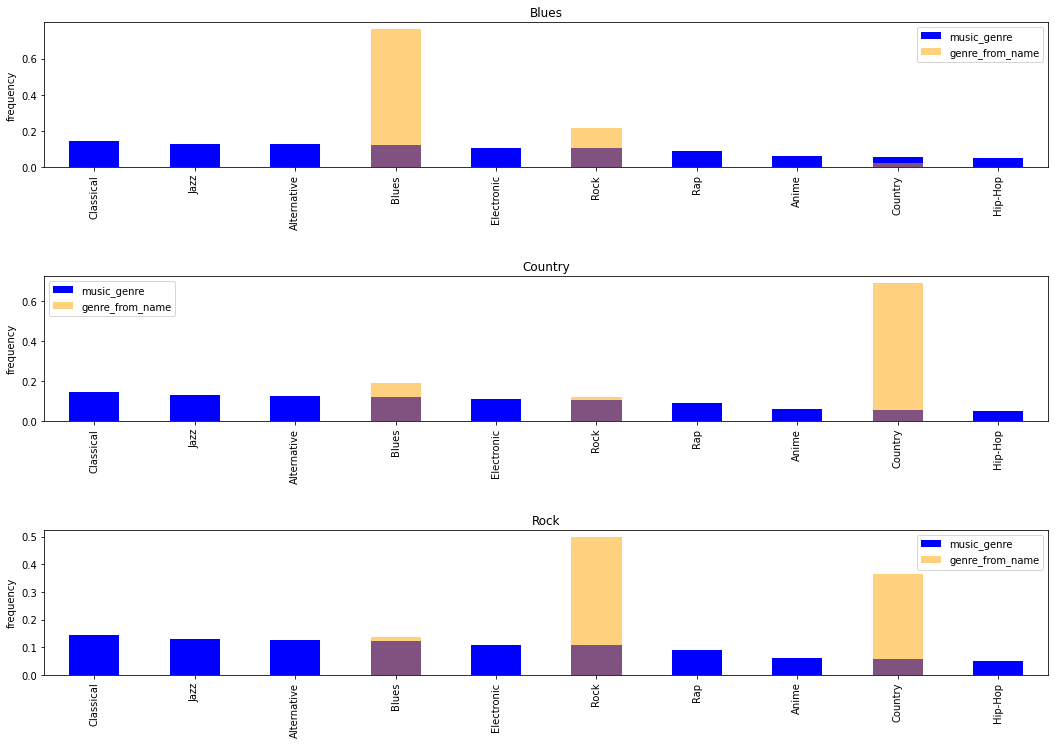

In [28]:
fig = plt.figure()
plt.subplots_adjust(hspace=0.75)

# Будем рассматривать только те жанры, которые часто встречаются в названии музыкального трека в качестве подстроки
for i, genre in enumerate(genre_freq[genre_freq >= 30].index):
    ax = fig.add_subplot(3, 1, i + 1)
    (decoded_train
     .music_genre
     .value_counts(normalize=True)
     .plot(kind='bar', ax=ax, color='blue')
    )
    (decoded_train[decoded_train.music_genre == genre]
     .genre_from_name
     .value_counts(normalize=True).reindex(decoded_train.music_genre.unique(), fill_value=0)
     .plot(kind='bar', ax=ax, color='orange', alpha=0.5)
    )
    ax.set_title(genre)
    ax.set_xlabel(None)
    ax.set_ylabel('frequency')
    ax.legend(['music_genre', 'genre_from_name'])

### Отобразим частоту совпадения жанра из поиска музыкальной библиотеки deezer и самого жанра

In [29]:
genre_crosstab = pd.crosstab(decoded_train['genre_from_deezer'], decoded_train['music_genre'])
genre_freq = genre_crosstab.sum(axis=1)
display(genre_crosstab.style.background_gradient(axis=None, cmap='Blues'))
display(genre_freq)

music_genre,Alternative,Anime,Blues,Classical,Country,Electronic,Hip-Hop,Jazz,Rap,Rock
genre_from_deezer,,,,,,,,,,
African Music,0,0,2,0,0,1,0,1,1,0
Alternative,261,9,164,2,12,95,11,16,15,226
Asian Music,0,113,3,1,1,1,2,0,0,0
Blues,0,0,4,0,0,0,0,0,0,0
Brazilian Music,0,0,0,0,0,1,0,3,0,0
Classical,1,18,8,264,0,3,0,3,1,1
Dance,6,5,1,1,1,117,0,11,7,4
Disco,0,0,0,0,0,0,0,1,0,0
Education,0,1,0,0,0,0,0,0,0,0


genre_from_deezer
African Music             5
Alternative             811
Asian Music             121
Blues                     4
Brazilian Music           4
Classical               299
Dance                   153
Disco                     1
Education                 1
Electro                 671
Film Scores               1
Films/Games             240
Folk                     34
Indian Music              1
Jazz                    241
Kids                      9
Latin Music              20
Metal                    61
Pop                     623
R&B                     217
Rap/Hip Hop            1528
Reggae                   12
Rock                   1251
Singer & Songwriter      19
Sports                    1
dtype: int64

### Проанализируем зависимость целевого признака от всех остальных

In [40]:
train_data.corr()['music_genre'].sort_values(ascending=False)

music_genre          1.0000
danceability         0.2655
speechiness          0.1882
obtained_date        0.0809
loudness             0.0478
mode                 0.0370
valence              0.0177
genre_from_deezer   -0.0002
genre_from_name     -0.0063
energy              -0.0119
key                 -0.0202
duration_ms         -0.0235
tempo               -0.0349
liveness            -0.0376
instrumentalness    -0.0607
acousticness        -0.0629
Name: music_genre, dtype: float64

### Краткий вывод:

Из небольшого исследования проведённого выше можно сформулировать гипотезу о том, что новые признаки `genre_from_name` и `genre_from_deezer` могут быть полезны в прогнозировании жанра

<div class="alert alert-success">🟢</div>

> Очень интересное исследование.  
> Кроме отмеченной тобой пользы, это исследование позволяет усомниться в качестве разметки входных данных, если экстраполировать эту маленькую выборку на весь набор.  
> Оно и неудивительно, если тот же last.fm относит, например, "Queen" к жанру pop.

## Выбор и обучение моделей

В качестве `baseline` будем использовать наивную модель `DummyClassifier` со стратегией `stratified`

In [169]:
dummy_model = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
dummy_model.fit(train_features, train_target)
dummy_predictions = dummy_model.predict(valid_features)
print(f'Значение F-beta для наивной модели на тестовых данных — {fbeta_score(valid_target, dummy_predictions, beta=0.5, average="weighted")}')

Значение F-beta для наивной модели на тестовых данных — 0.10249117704653027


In [29]:
tree_search = RandomizedSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
                                 param_distributions={
                                     'criterion': ['gini', 'entropy'],
                                     'max_depth': list(range(1, 51)),
                                     'min_samples_split': list(range(2, 12))
                                 },
                                 n_iter=200,
                                 n_jobs=-1,
                                 cv=5,
                                 verbose=10).fit(train_features, train_target)
forest_search = RandomizedSearchCV(RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
                                   param_distributions={
                                       'criterion': ['gini', 'entropy'],
                                       'max_depth': list(range(1, 51)),
                                       'n_estimators': list(range(1, 101)),
                                   },
                                   n_iter= 200,
                                   n_jobs=-1,
                                   cv=5,
                                   verbose=10).fit(train_features, train_target)
boosting_search = RandomizedSearchCV(GradientBoostingClassifier(random_state=RANDOM_STATE),
                                     param_distributions={
                                         'max_depth': list(range(1, 11)),
                                         'learning_rate': [0.01, 0.05, 0.1, 0.25],
                                         'n_estimators': list(range(1, 101)),
                                         'min_samples_split': list(range(2, 12))
                                     },
                                     n_iter=200,
                                     n_jobs=-1,
                                     cv=5,
                                     verbose=10).fit(train_features, train_target)

Fitting 4 folds for each of 100 candidates, totalling 400 fits
[CV 1/4; 1/100] START criterion=entropy, max_depth=38, min_samples_split=3......
[CV 1/4; 1/100] END criterion=entropy, max_depth=38, min_samples_split=3;, score=0.354 total time=   0.4s
[CV 2/4; 1/100] START criterion=entropy, max_depth=38, min_samples_split=3......
[CV 2/4; 1/100] END criterion=entropy, max_depth=38, min_samples_split=3;, score=0.358 total time=   0.4s
[CV 3/4; 1/100] START criterion=entropy, max_depth=38, min_samples_split=3......
[CV 3/4; 1/100] END criterion=entropy, max_depth=38, min_samples_split=3;, score=0.363 total time=   0.4s
[CV 4/4; 1/100] START criterion=entropy, max_depth=38, min_samples_split=3......
[CV 4/4; 1/100] END criterion=entropy, max_depth=38, min_samples_split=3;, score=0.362 total time=   0.4s
[CV 1/4; 2/100] START criterion=entropy, max_depth=32, min_samples_split=10.....
[CV 1/4; 2/100] END criterion=entropy, max_depth=32, min_samples_split=10;, score=0.351 total time=   0.4s
[

In [33]:
predictions = tree_search.predict(valid_features)
fbeta_score(valid_target, predictions, beta=0.5, average='macro')

0.39896040067501587

In [34]:
predictions = forest_search.predict(valid_features)
fbeta_score(valid_target, predictions, beta=0.5, average='macro')

0.47644560813363523

In [35]:
predictions = boosting_search.predict(valid_features)
fbeta_score(valid_target, predictions, beta=0.5, average='macro')

0.48630974649736264

In [37]:
pd.DataFrame(boosting_search.predict(test_data), columns=['music_genre'], index=pd.read_csv('./test_updated.csv').instance_id).to_csv('./sample_submit1.csv')

<div class="alert alert-success">🟢</div>

> Отлично, что делаешь автоматизированный подбор гиперпараметров!

> Попробуй какую-нибудь более продвинутую библиотеку для подбора гиперпараметров, например, [**Optuna**](https://optuna.org/). Время, потраченное на изучение, быстро окупится в работе.  
> Для первого знакомства у нее есть такая отличная штука — [**OptunaSearchCV**](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.integration.OptunaSearchCV.html). Интерфейс практически такой же, как у **RandomizedSearchCV**, поэтому очень легко начать пользоваться таким полезным инструментом.

## Итоговая оценка качества предсказания лучшей модели и анализ важности ее признаков

## Общий вывод

**1) Загрузка и ознакомление с данными:** \
**2) Предварительная обработка:** \
**3) Исследовательский анализ данных:** \
**4) Выбор и обучение моделей:** \
**5) Итоговая оценка качества предсказания лучшей модели:**

<div class="alert alert-success">🟢</div>

> Отличный и неординарный проект, читал с большим интересом!
> 
> Соревнование предполагает использование всех своих знаний по максимуму, чтобы вместе они сложились в достойный результат.  
> Ты проделал большую работу и, надеюсь, результат в соревновании тебя порадовал.

> Хочу отметить:
> - структуру и регулярные комментарии: проект читается легко;
> - высокий уровень владения python и аккуратный код;
> - обширный и нешаблонный EDA с интересными визуализациями;
> - интересные техники для заполнения пропущенных значений;
> - неординарную работу с неявными дубликатами.

> Чтобы улучшить этот проект рекомендую:
> - feature engineering на базе числовых признаков;
> - исследование потенциальной значимости признаков;
> - использование пайплайнов: код станет еще чище;
> - стандартизацию данных: хуже точно не сделает;
> - попробовать поискать нелинейные зависимости: в библиотеке sklearn есть хорошие [методы](https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html).
> - библиотеку **Optuna** для оптимизации гиперпараметров;
> - анализ значимости признаков по результатам моделирования: **permutation importance**, **SHAP**.

> Получился очень достойный проект для портфолио.

<div class="alert alert-success">🟢</div>

> Отчет — важная часть проекта. Часто именно с него начинается изучение проекта заказчиком.  
> И желательно сразу показать заказчику, что все выполнено на лучшем уровне.
> 
> На всякий случай оставлю тебе развернутые рекомендации, как должен выглядеть отчет. Наверняка, тебе это пригодится в будущем.
    
---
    
> Отчет — это подведение итогов исследования, основные выводы и рекомендации, который в реальной работе будет читать заказчик. В идеале — отчет должен быть таким, чтобы по нему можно было воспроизвести проект, не смотря в код.
>
> В отчете важно отразить следующие моменты исследования:  
> 1. Полное ли решение (описание проекта, название, цели задачи, исходные данные).  
> 1. Сравнение итогового решения с планом (если есть отклонения от плана объяснить почему).
> 1. Затруднения в ходе исследования и подготовки решения (описание трудности, способ ее решения).  
> 1. Ключевые шаги решения (наиболее важные моменты в ходе исследования).  
> 1. Итоговая модель (с объяснением причины выбора).  
> 1. Сравнение моделей (на валидации/трейне, тесте).  
> 1. Описание признаков, которые используются для обучения (объяснено почему именно они).  
> 1. Описание процесса предобработки данных (что сделано с данными и почему).  
> 1. Рекомендации по внедрению модели и дальнейшей поддержке (дообучению или улучшению метрики качества).  
> 1. Наличие четкой структуры исследования и оформление.  
> 
> Можно, но необязательно, подготовить полноценный отчет по исследовательской работе датасайентиста.  
> Примеры хороших отчетов можно посмотреть на сайте **Stanford University** — [отчеты по финальным проектам направления Machine Learning](https://cs229.stanford.edu/projects2014.html).  
> Из примеров понятно наполнение отчета по исследованию, а так же, что главное, – понятна сама структура отчета. В реальной работе именно такой формат отчета обычно завершает исследование.